In [17]:
import os
import tensorflow as tf
from tensorflow import keras

In [7]:
os.environ["KAGGLE_CONFIG_DIR"] ="/content/drive/MyDrive/kaggle"

In [8]:
!kaggle competitions download -c dogs-vs-cats

 97% 262M/271M [00:01<00:00, 178MB/s]
100% 271M/271M [00:01<00:00, 154MB/s]
 98% 534M/543M [00:03<00:00, 162MB/s]
100% 543M/543M [00:03<00:00, 160MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 72.1MB/s]


In [ ]:
# upload the data

In [9]:
import zipfile
from zipfile import ZipFile

file_name = "/content/train.zip"

with zipfile.ZipFile(file_name, 'r') as zipref:
  zipref.extractall()
  print("done")

done


In [10]:
data_dir_list =os.listdir('/content/train')

path, dirs, files = next(os.walk("/content/train"))
file_count =len(files)
print(file_count)

original_dataset_dir ='/content/train'
base_dir ='/content/cats_and_dogs_smalls'
os.mkdir(base_dir)

25000


In [11]:

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)



In [12]:
import shutil
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
                    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [13]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
# total training cat images: 1000
print('total training dog images:', len(os.listdir(train_dogs_dir)))
# total training dog images: 1000
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
# total validation cat images: 500
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
# total validation dog images: 500
print('total test cat images:', len(os.listdir(test_cats_dir)))
# total test cat images: 500
print('total test dog images:', len(os.listdir(test_dogs_dir)))
# total test dog images: 500

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [ ]:
# Feature extraction
# Listing 5.16 Instantiating the VGG16 convolutional base

In [33]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [34]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION
# Listing 5.17 Extracting features using the pretrained convolutional base

In [36]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir ='/content/cats_and_dogs_smalls'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [37]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

In [ ]:
# Listing 5.18 Defining and training the densely connected classifier

In [40]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(train_features, train_labels,
epochs=30,
batch_size=20,
validation_data=(validation_features, validation_labels))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
100/100 [==============================] - 1s 8ms/step - loss: 0.6144 - acc: 0.6590 - val_loss: 0.4642 - val_acc: 0.8300
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4365 - acc: 0.8045 - val_loss: 0.3724 - val_acc: 0.8610
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3663 - acc: 0.8370 - val_loss: 0.3305 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3107 - acc: 0.8735 - val_loss: 0.3059 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2847 - acc: 0.8855 - val_loss: 0.2966 - val_acc: 0.8770
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2706 - acc: 0.8920 - val_loss: 0.2804 - val_acc: 0.8950
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2519 - acc: 0.8970 - val_loss: 0.2718 - val_acc: 0.8890
Epoch 8/30
100/100 [==============================] - 1s 6ms/step - loss: 0.

In [ ]:
# plot the curve

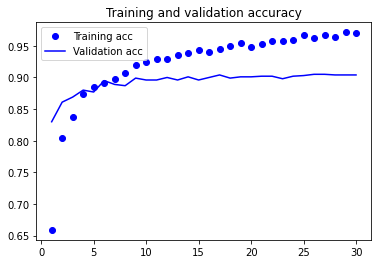

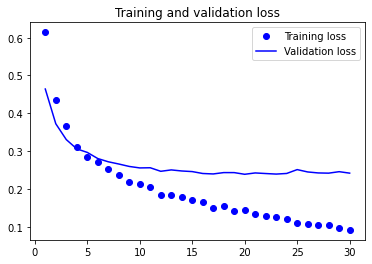

In [41]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:

# Listing 5.20 Adding a densely connected classifier on top of the convolutional base


In [42]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [43]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [45]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))
# This is the number of trainable weights before freezing the conv base: 30
conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))
# This is the number of trainable weights after freezing the conv base: 4

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [ ]:
# Listing 5.21 Training the model end to end with a frozen convolutional base with 30 epocs and lr = 2e-5.

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=2e-5),
metrics=['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 28s 269ms/step - loss: 0.5892 - acc: 0.6890 - val_loss: 0.4455 - val_acc: 0.8350
Epoch 2/30
100/100 [==============================] - 27s 265ms/step - loss: 0.4728 - acc: 0.7935 - val_loss: 0.3634 - val_acc: 0.8630
Epoch 3/30
100/100 [==============================] - 26s 264ms/step - loss: 0.4273 - acc: 0.8055 - val_loss: 0.3508 - val_acc: 0.8530
Epoch 4/30
100/100 [==============================] - 26s 264ms/step - loss: 0.3965 - acc: 0.8250 - val_loss: 0.3127 - val_acc: 0.8830
Epoch 5/30
100/100 [==============================] - 26s 262ms/step - loss: 0.3791 - acc: 0.8405 - val_loss: 0.3016 - val_acc: 0.8840
Epoch 6/30
100/100 [==============================] - 26s 264ms/step - loss: 0.3695 - acc: 0.8380 - val_loss: 0.2825 - val_acc: 0.8860
Epoch 7/30
100/100 [==============================] - 26s 263ms/step - loss: 0.3563 - acc: 0.8420 - val_loss: 0.2798 - val_acc: 0.8890
Epoch 8/30
100/100 [==============================] - 2

In [ ]:
# Plotting the results

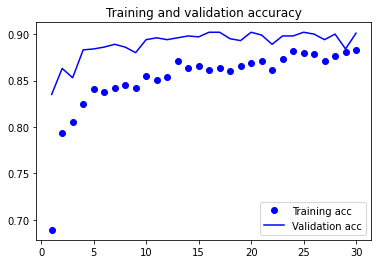

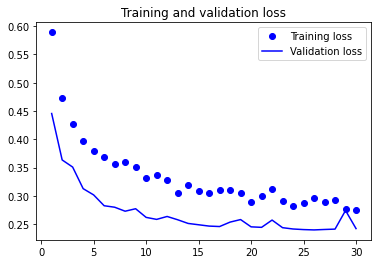

In [48]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
 # Training the model end to end with a frozen convolutional base with 20 epochs and lr = 2e-3.

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=2e-3),
metrics=['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=20,
validation_data=validation_generator,
validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 28s 268ms/step - loss: 1.0694 - acc: 0.7035 - val_loss: 0.3629 - val_acc: 0.8130
Epoch 2/20
100/100 [==============================] - 26s 264ms/step - loss: 0.4749 - acc: 0.7755 - val_loss: 0.2751 - val_acc: 0.8880
Epoch 3/20
100/100 [==============================] - 27s 266ms/step - loss: 0.4057 - acc: 0.8165 - val_loss: 0.3791 - val_acc: 0.8270
Epoch 4/20
100/100 [==============================] - 26s 264ms/step - loss: 0.3875 - acc: 0.8250 - val_loss: 0.4021 - val_acc: 0.8170
Epoch 5/20
100/100 [==============================] - 27s 267ms/step - loss: 0.3789 - acc: 0.8350 - val_loss: 0.2625 - val_acc: 0.8950
Epoch 6/20
100/100 [==============================] - 26s 265ms/step - loss: 0.3716 - acc: 0.8250 - val_loss: 0.2455 - val_acc: 0.9100
Epoch 7/20
100/100 [==============================] - 27s 265ms/step - loss: 0.3587 - acc: 0.8385 - val_loss: 0.2563 - val_acc: 0.8920
Epoch 8/20
100/100 [==============================] - 2

In [ ]:
# Plotting the results

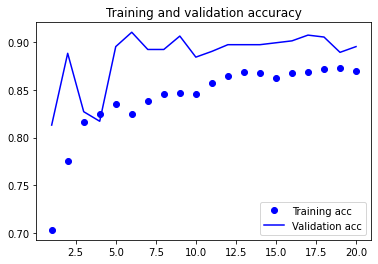

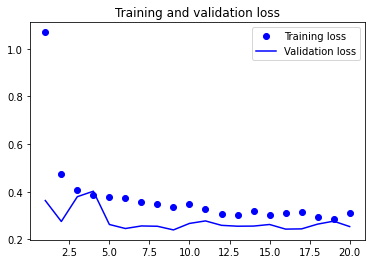

In [50]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Training the model end to end with a frozen convolutional base with 06 epocs and learning rate =2e-3

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=2e-3),
metrics=['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=6,
validation_data=validation_generator,
validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
100/100 [==============================] - 28s 271ms/step - loss: 0.2953 - acc: 0.8750 - val_loss: 0.2814 - val_acc: 0.8970
Epoch 2/6
100/100 [==============================] - 27s 266ms/step - loss: 0.2806 - acc: 0.8800 - val_loss: 0.2452 - val_acc: 0.9040
Epoch 3/6
100/100 [==============================] - 27s 266ms/step - loss: 0.2803 - acc: 0.8780 - val_loss: 0.2594 - val_acc: 0.8970
Epoch 4/6
100/100 [==============================] - 27s 265ms/step - loss: 0.2869 - acc: 0.8795 - val_loss: 0.2627 - val_acc: 0.8990
Epoch 5/6
100/100 [==============================] - 27s 266ms/step - loss: 0.2741 - acc: 0.8870 - val_loss: 0.3083 - val_acc: 0.8880
Epoch 6/6
100/100 [==============================] - 26s 265ms/step - loss: 0.2863 - acc: 0.8750 - val_loss: 0.2652 - val_acc: 0.9030


In [ ]:
# Plotting the results

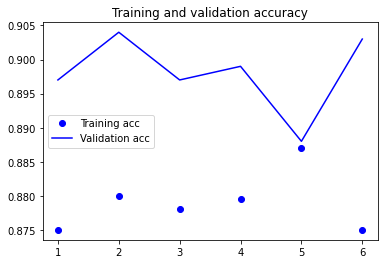

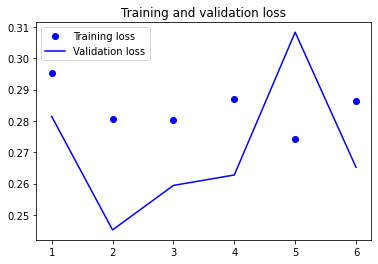

In [52]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# convolutional base looks like:

In [54]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# Listing 5.22 Freezing all layers up to a specific one

In [56]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
if set_trainable:
        layer.trainable = True
else:
    layer.trainable = False

In [ ]:
# Listing 5.23 Fine-tuning the model

In [57]:
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-5),
metrics=['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=100,
validation_data=validation_generator,
validation_steps=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 48s 423ms/step - loss: 0.2949 - acc: 0.8820 - val_loss: 0.2138 - val_acc: 0.9290
Epoch 2/100
100/100 [==============================] - 42s 419ms/step - loss: 0.2161 - acc: 0.9135 - val_loss: 0.2722 - val_acc: 0.9210
Epoch 3/100
100/100 [==============================] - 42s 419ms/step - loss: 0.1876 - acc: 0.9270 - val_loss: 0.1638 - val_acc: 0.9410
Epoch 4/100
100/100 [==============================] - 42s 419ms/step - loss: 0.1698 - acc: 0.9295 - val_loss: 0.6037 - val_acc: 0.8820
Epoch 5/100
100/100 [==============================] - 42s 418ms/step - loss: 0.1421 - acc: 0.9385 - val_loss: 0.1522 - val_acc: 0.9460
Epoch 6/100
100/100 [==============================] - 42s 418ms/step - loss: 0.1407 - acc: 0.9405 - val_loss: 0.1329 - val_acc: 0.9430
Epoch 7/100
100/100 [==============================] - 42s 418ms/step - loss: 0.1174 - acc: 0.9540 - val_loss: 0.1301 - val_acc: 0.9540
Epoch 8/100
100/100 [===========================

In [ ]:
# Plotting the results

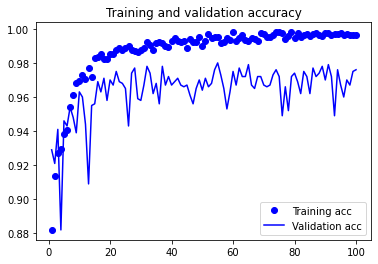

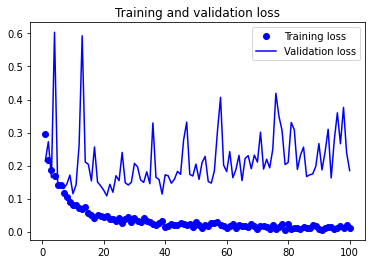

In [58]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Figure 5.23 Smoothed curves for training and validation loss for fine-tuning

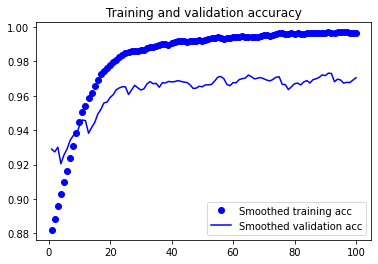

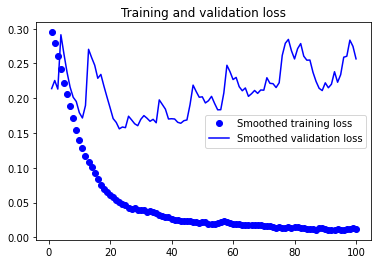

In [60]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
       previous = smoothed_points[-1]
       smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#  finally evaluate this model on the test data:

In [61]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9649999737739563
